# Social Data Analysis - Explainer Notebook

This notebook contains the different explanations to the idea behind the webside, the basic data and the different visualization we chose. 

## General idea and data

Since the current pandemic in the world has such a huge impact on our lives, we wanted to work with data of the corona virus. However, just visualizing the pandemic, how it evolved and spread was something that was done before and would not be something specifically new. Thereby we searhced for an angle that could be done with the corona virus. After searching for data, a few ideas came to mind:
* Using twitter data to look at the spread around the world.
* Looking at the different stay-at-home orders in the US and how it had affected people.
* How it affected the crime-situation around the world.

It was quickly realized, that the twitter-data was not possible to get a nice visualization from in the aspects we wanted. Thereby we scrapped that and went with a combination of the two other ideas. It was rather easy to accquire data from Chicago about the crime development throughout the years (like we did with SF) and using this to look at how the crimes have evolved in the city after the corona virus outbreak could then be done.

We thereby wanted to look at the corona-spread in Illinois and how it has affected crimes in Chicago, which types of crimes, locations of the crimes and end it with a bit of machine learning to get a feeling on how it can be used. Furthermore, a study was found showing how much people were moving in the United States, i.e. if people are at home or not. Here is an overview of where the data was from:

* The Corona data for confirmed can be found [here]('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv') and for the deaths can be found [here]('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'). It is essentially data from the US in general, but can easily be filtered to only contain data from the counties in Illinois.
* The travelling data (how much people travel in the different counties) can be found [here](https://www.descarteslabs.com/mobility/). It is a study by Descartes Labs and they have data of the median of movement in every county in the US. For us it is only relevant to look at Cook County, Illinois, since that is where Chicago is located.
* Crime data can be gotten from the Chicago City Portal [here](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2) It shows crimes from 2001 to present, and can therefore be used to compare to other years. This is relevant to see how much the outbreak has made deviations in different types of crimes this year compared to others.

The data is quite large. Especially the crime data with a size of approximately 1.5 gigabytes.

The general idea of the web page is then to be relvant to everyone. Telling a story of how the crimes have been affected and make nice visualizations to show it such that the user can delve deeper into where the effect of the lack of crimes can be seen and which types of crimes are most affected, making it accesible to everyone who finds it interesting without prior knowledge of data analysis. Something that other sources have not done, since not a lot of articles actually show visualizations of the crimes.

## Basic Stats

In this section we will look at the basic stats about the data we are using. This includes the Corona-data, the movement data and the crime data.

### Corona data

The data is cleaned such that we only look at the state of Illinois and the city of Chicago. Thereby we filter all data out, that is not a part of that state or that city. County-wise, we select to focus on Cook County, given that the county is where Chicago is located. However, we start off by looking at Illinois. 


In [1]:
# Packages
import pandas as pd
import numpy as np # For data handling
import matplotlib.pyplot as plt # For plotting
import datetime as dt
import urllib
import geojson
import folium

# Load the data
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
confirmedUS = pd.read_csv(url)

url2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
deathsUS = pd.read_csv(url2)

# Filter by Illinois and print size
print(confirmedUS[confirmedUS["Province_State"]=="Illinois"].size)
print(deathsUS[deathsUS["Province_State"]=="Illinois"].size)

# Show head of data:
confirmedUS[confirmedUS["Province_State"]=="Illinois"].head(2)

13000
13104


UID iso2 iso3  code3     FIPS     Admin2 Province_State  \
600  84017001   US  USA    840  17001.0      Adams       Illinois   
601  84017003   US  USA    840  17003.0  Alexander       Illinois   

    Country_Region        Lat      Long_  ... 5/5/20  5/6/20  5/7/20  5/8/20  \
600             US  39.988156 -91.187868  ...     40      40      40      41   
601             US  37.180493 -89.329108  ...      4       6       6       6   

     5/9/20  5/10/20  5/11/20  5/12/20  5/13/20  5/14/20  
600      41       41       41       41       41       41  
601       6        7        7        8        8        8  

[2 rows x 125 columns]

We can here see how the data is generally presented in the corona-data. There is a column for each date and a column for the locations. Further, there is columns showing the province, the county (Admin2) and some other values that are not so relevant.

Looking at the state of Illinois, we see how it has evolved over time. It is expected that it would be exponential, since a virus has an exponential spread. This can be plotted the following way:

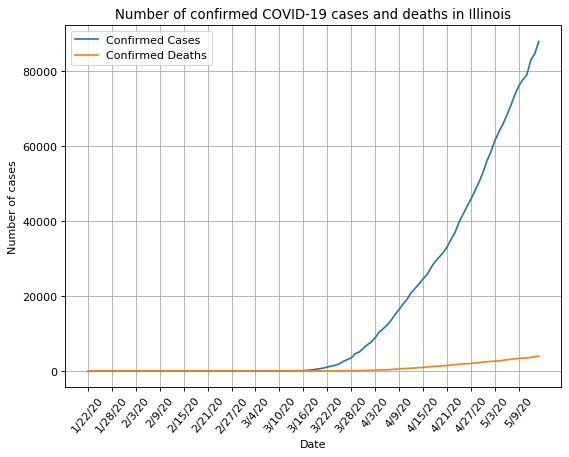

In [2]:
# Rename columns:
confirmedUS = confirmedUS.rename(columns={"Admin2": "County"})
deathsUS = deathsUS.rename(columns = {"Admin2": "County"})

# Get data from Illinois (confirmed)
illiData = confirmedUS[confirmedUS["Province_State"] == "Illinois"]
illiData = illiData.reset_index()

# Get data from Illinois (deaths)
illiDeaths = deathsUS[confirmedUS["Province_State"] == "Illinois"]
illiDeaths = illiDeaths.reset_index()

## Get data for the states (meaning total number of cases for each state, disregarding counties)
# First, sum the different states, if more entries of one state
tmp = illiData.groupby("Province_State").sum()
tmp2 = illiDeaths.groupby("Province_State").sum()

# Transpose the data frame:
StateData = tmp.T
StateDeaths = tmp2.T

# Remove unwanted rows:
StateData = StateData.drop(StateData.index[0:6])
StateDeaths = StateDeaths.drop(StateDeaths.index[0:7])

# Prepare the data for plotting:
StateData = StateData.reset_index()
StateData = StateData.rename(columns={"index": "Date"})
StateDeaths = StateDeaths.reset_index()
StateDeaths = StateDeaths.rename(columns={"index": "Date"})

dats = StateData["Date"]

# Plot the data
fig=plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(dats,StateData["Illinois"], label = "Confirmed Cases")
plt.plot(dats,StateDeaths["Illinois"], label = "Confirmed Deaths")
plt.xticks(np.arange(0, len(dats), step=6), dats[np.arange(0, len(dats), step=6)], rotation=50);
plt.xlabel("Date");
plt.ylabel("Number of cases");
plt.title("Number of confirmed COVID-19 cases and deaths in Illinois");
plt.legend()
plt.grid();

We see the data has a general exponential growth. This is due to the rapid increase in cases in Illinois. The same could also be done for Cook county. However, the plot is very similar, so we will not do that. Another thing to look at is the crime data, gotten from the Chicago city portal.


### Crime Data

When analyizing the crime data, we will filter it by focus crimes. The focus crimes chosen are the following:

* Assault.
* Battery.
* Depective Practice.
* Motor Vehicle Theft.
* Narcotics
* Robbery
* Theft
* Criminal Damage

First let us look at how the crime data is set up. For simplicity, we will only look at the data from 2020 in this section. However, the data is the same for the other years.


In [3]:
# Load the data
crimeDat = pd.read_csv("CrimesChicago.csv")

C:\Users\neelj\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Data 2020 (extract data from 2020)
dat2020 = crimeDat[crimeDat["Year"] >= 2020]
dat2020 = dat2020.reset_index()
dat2020["Date"] = pd.to_datetime(dat2020["Date"])
dat2020.head()

index        ID Case Number                Date  \
0  187735  11946909    JD109980 2020-01-09 14:25:00   
1  187903  11946915    JD110189 2020-01-09 16:58:00   
2  188260  11946931    JD110284 2020-01-09 20:25:00   
3  188261  11946971    JD109951 2020-01-09 15:53:00   
4  189614  11947070    JD110194 2020-01-09 18:46:00   

                                 Block  IUCR         Primary Type  \
0                  059XX S ASHLAND AVE  0910  MOTOR VEHICLE THEFT   
1                  076XX S STEWART AVE  0610             BURGLARY   
2                 012XX S MICHIGAN AVE  1154   DECEPTIVE PRACTICE   
3                     048XX W RACE AVE  0486              BATTERY   
4  043XX S DR MARTIN LUTHER KING JR DR  143A    WEAPONS VIOLATION   

                               Description         Location Description  \
0                               AUTOMOBILE  AUTO / BOAT / RV DEALERSHIP   
1                           FORCIBLE ENTRY                    APARTMENT   
2  FINANCIAL IDENTITY THEFT $300 AND UNDER                          NaN   
3                  DOMESTIC BATTERY SIMPLE                       STREET   
4                 UNLAWFUL POSS OF HANDGUN                       STREET   

   Arrest  ...  Ward  Community Area  FBI Code  X Coordinate  Y Coordinate  \
0   False  ...  16.0            67.0        07     1166690.0     1865304.0   
1   False  ...  17.0            69.0        05     1174949.0     1854311.0   
2   False  ...   3.0            33.0        11     1177422.0     1894769.0   
3   False  ...  28.0            25.0       08B     1144164.0     1903225.0   
4    True  ...   3.0            38.0        15     1179582.0     1876300.0   

   Year              Updated On   Latitude  Longitude  \
0  2020  01/16/2020 03:49:10 PM  41.785960 -87.664375   
1  2020  01/16/2020 03:49:10 PM  41.755613 -87.634421   
2  2020  01/16/2020 03:49:10 PM  41.866578 -87.624134   
3  2020  01/16/2020 03:49:10 PM  41.890471 -87.746016   
4  2020  01/16/2020 03:49:10 PM  41.815849 -87.616771   

                        Location  
0     (41.78595959, -87.6643748)  
1  (41.755613227, -87.634420924)  
2  (41.866578077, -87.624134464)  
3  (41.890471431, -87.746016415)  
4  (41.815848621, -87.616770643)  

[5 rows x 23 columns]

We see the data is very similar to the SF crime data we have worked with in the course. It shows the coordinates of the crimes, the type of crime and so on. Also the time of when it has happened. This is very useful since the different features of the data can be used for different visualizations. The following plot of the crime types can be seen. This shows the number of registered crimes for each type during 2020.

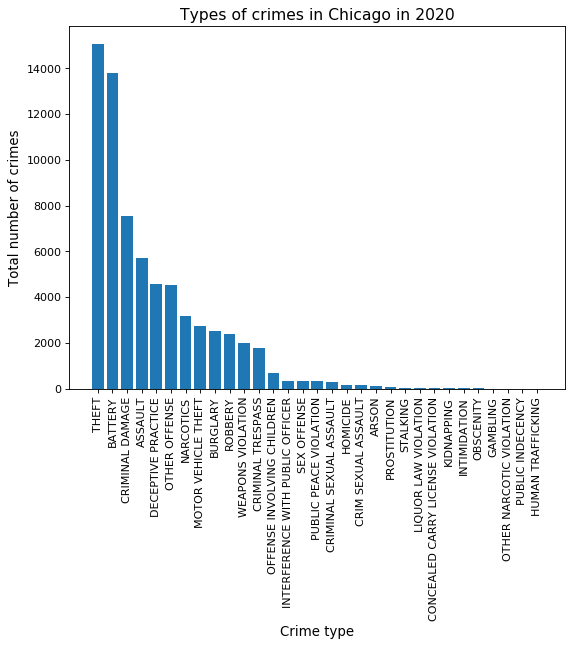

In [5]:
tmp = dat2020.groupby("Primary Type").size()
tmp = tmp.sort_values(ascending = False)
plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(tmp.index, tmp)
plt.xticks(rotation = 90);
plt.title("Types of crimes in Chicago in 2020", size = 14);
plt.xlabel("Crime type", size = 12);
plt.ylabel("Total number of crimes", size = 12);

As it can be seen, the focus crimes have more samples and are thereby better to use for data visualizations, since not a lot of information can be gathered from crimes that are not as common. 

Another thing to look at, which is also looked at on the web page is the amount of crimes in 2020. The plot looks like the following:

In [6]:
# Data 2020
dat2020 = crimeDat[crimeDat["Year"] >= 2020]
dat2020 = dat2020.reset_index()
dat2020["Date"] = pd.to_datetime(dat2020["Date"])
# Data 2019
dat2019 = crimeDat[crimeDat["Year"] == 2019]
dat2019 = dat2019.reset_index()
dat2019["Date"] = pd.to_datetime(dat2019["Date"])
# Prepare data
tmp = dat2020["Date"].max()
dat2020["DateNew"] = dat2020["Date"].dt.date
dat2019["DateNew"] = dat2019["Date"].dt.date
dat2019 = dat2019[dat2019["DateNew"] <= dt.date(year=2019,month=tmp.month,day=tmp.day)]
dat2020["DayMonth"] = dat2020.DateNew.map(lambda x: x.strftime('%m-%d'))
dat2020 = dat2020[dat2020["DayMonth"] != '02-29']

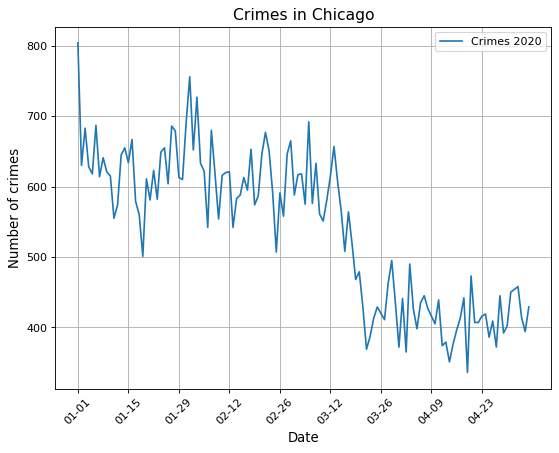

In [7]:
# # Get data:
plotdata2020 = dat2020.groupby("DayMonth").size()
dates2020 = plotdata2020.index.to_numpy()
plotdata2020 = plotdata2020.to_numpy()

plotdata2019 = dat2019.groupby("DateNew").size()
dates2019 = plotdata2019.index.to_numpy()
plotdata2019 = plotdata2019.to_numpy()

# Plot:
plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(dates2020, plotdata2020, label = "Crimes 2020");
#plt.plot(dates2020, plotdata2019, label = "Crimes 2019");
#plt.axvline(x="03-21", color = "black", label="Stay-at-home order")
plt.legend();
plt.xticks(dates2020[::14], rotation = 45);
plt.xlabel("Date", size = 12);
plt.title("Crimes in Chicago", size = 14)
plt.grid()
plt.ylabel("Number of crimes", size = 12);

As it can be seen, the data drops rapidly around march of 2020. This is the core aspect of the web page. We want to look at why and which crimes have dropped significantly from the rest to get an overview of the impact of the corona-virus. In the web page, plots like comparing to other years can also be seen. This is just showing the crimes for 2020. 

### Movement data

Last data to look at is the movement data done by Descartes Labs. It shows the median of the maximum distance travelled by county in the US taken from some samples. The data itself looks like the following:

In [8]:
## Load the mobility data
url3 = 'https://raw.githubusercontent.com/descarteslabs/DL-COVID-19/master/DL-us-mobility-daterow.csv'
mobility = pd.read_csv(url3)
mobility = mobility.rename(columns = {"admin1": "State", "admin2": "County"})
illiMob = mobility[mobility["State"] == "Illinois"]
illiMob = illiMob.reset_index()
illiMob

index        date country_code  admin_level     State           County  \
0     37613  2020-03-01           US            1  Illinois              NaN   
1     37614  2020-03-02           US            1  Illinois              NaN   
2     37615  2020-03-03           US            1  Illinois              NaN   
3     37616  2020-03-04           US            1  Illinois              NaN   
4     37617  2020-03-05           US            1  Illinois              NaN   
...     ...         ...          ...          ...       ...              ...   
6747  44360  2020-05-08           US            2  Illinois  Woodford County   
6748  44361  2020-05-09           US            2  Illinois  Woodford County   
6749  44362  2020-05-10           US            2  Illinois  Woodford County   
6750  44363  2020-05-11           US            2  Illinois  Woodford County   
6751  44364  2020-05-12           US            2  Illinois  Woodford County   

         fips  samples    m50  m50_index  
0        17.0   230203  5.142         70  
1        17.0   241730  7.092         97  
2        17.0   247251  7.263        100  
3        17.0   253725  7.255         99  
4        17.0   246790  7.506        103  
...       ...      ...    ...        ...  
6747  17203.0     1163  8.797         63  
6748  17203.0     1219  7.670         55  
6749  17203.0     1206  1.992         14  
6750  17203.0     1061  4.063         29  
6751  17203.0     1195  9.219         66  

[6752 rows x 10 columns]

The data column m50 shows median of the maximum distance travlled within every county of Illinois. The reason why the median is good to use, is that if some people travel very far it will skew the data. Therefore, taking the median ensures that outliers are not skewing the overall number describing the distance travelled. There are also a column called samples, which is the number of samples used for the data. We can plot it for Cook County and see how it has evolved over time.

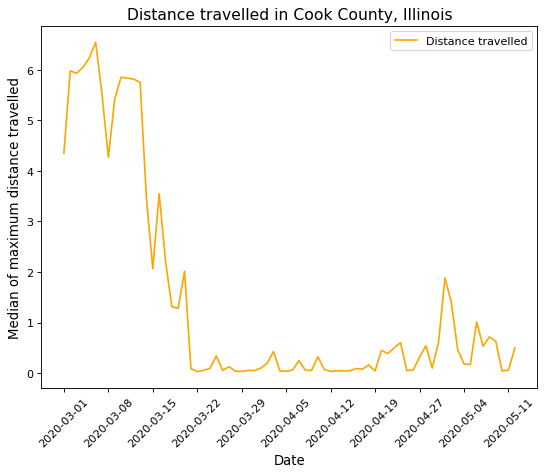

In [9]:
# Plot at test. Let us focus on Cook County, which is where Chicago is.
test = illiMob[illiMob["County"] == "Cook County"]
dates = test["date"]
fig=plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(dates, test["m50"], color = "orange", label = "Distance travelled")
#plt.axvline(x="2020-03-21", color = "black", label="Stay-at-home order")
plt.title("Distance travelled in Cook County, Illinois", size = 14)
plt.ylabel("Median of maximum distance travelled", size = 12)
plt.xlabel("Date", size = 12)
#plt.grid()
plt.legend()
plt.xticks(dates[::7], rotation = 45);

As we see, unsurprisingly the median of the maximum distance travlled falls rather rapidly around march. 

That concludes looking at the basic stats of the data.

## Data Analysis

In this section, the data analysis performed on the web page will be outlined. As explained, the overall goal is to provide inside to the user of how the crimes have developed over time in Chicago.

### Corona data

First we will get a deeper understanding of the corona data within the state of Illinois. More specifically, where there is a lot of cases and where there is not a lot of cases. This is to get a general overview along with seeing how bad the situation in Chicago is compared to the situation in the state. We can sort the data by county and create a plot to see where the situation is bad. The plot is logaritmic to show a better overview.


C:\Users\neelj\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


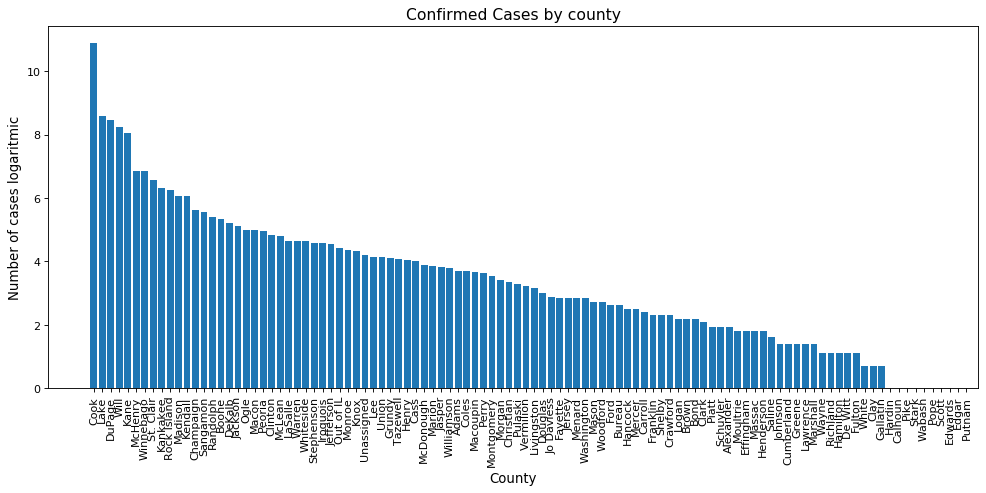

In [10]:
# Get the data
tmp = illiData[["County", "5/11/20"]]
tmp = tmp.sort_values("5/11/20", ascending = False)


# Plot (logaritmic)
fig=plt.figure(figsize=(15, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(tmp["County"], np.log(tmp["5/11/20"]))
#plt.axvline(x="2020-03-21", color = "black", label="Stay-at-home order")
plt.title("Confirmed Cases by county", size = 14)
plt.ylabel("Number of cases logaritmic", size = 12)
plt.xlabel("County", size = 12)
#plt.grid()
plt.xticks(rotation = 90);

As we see, the current situation is much worse in Cook county than in the others. This makes sense, since it is where Chicago is located. Therefore we can further look at Cook county and see how it has developed. However, the corona-data is mostly used for exploratory data analysis, since the real data-analysis comes from the crime data found and the corona data creates a basis and explanation on why the crime data looks like it does.

### Crime data

The basis of the analysis is seeing how the crime data in 2020 differs from other years. The best point of comparison is 2019, since it is the most recent year. If other years were chosen, other aspects of the data might influence it - like difference in amount of money used for the police department, financial differences etc. 

Using 2019 is therefore the best choice when comparing. We load the data as before:

In [11]:
# ## Load the data
# crimeDat = pd.read_csv("CrimesChicago.csv")

In [12]:
# # Data 2020
# dat2020 = crimeDat[crimeDat["Year"] >= 2020]
# dat2020 = dat2020.reset_index()
# dat2020["Date"] = pd.to_datetime(dat2020["Date"])
# # Data 2019
# dat2019 = crimeDat[crimeDat["Year"] == 2019]
# dat2019 = dat2019.reset_index()
# dat2019["Date"] = pd.to_datetime(dat2019["Date"])
# # Prepare data
# tmp = dat2020["Date"].max()
# dat2020["DateNew"] = dat2020["Date"].dt.date
# dat2019["DateNew"] = dat2019["Date"].dt.date
# dat2019 = dat2019[dat2019["DateNew"] <= dt.date(year=2019,month=tmp.month,day=tmp.day)]
# dat2020["DayMonth"] = dat2020.DateNew.map(lambda x: x.strftime('%m-%d'))
# dat2020 = dat2020[dat2020["DayMonth"] != '02-29']

Now we can look at something like the total amount of cases to see that it differs:

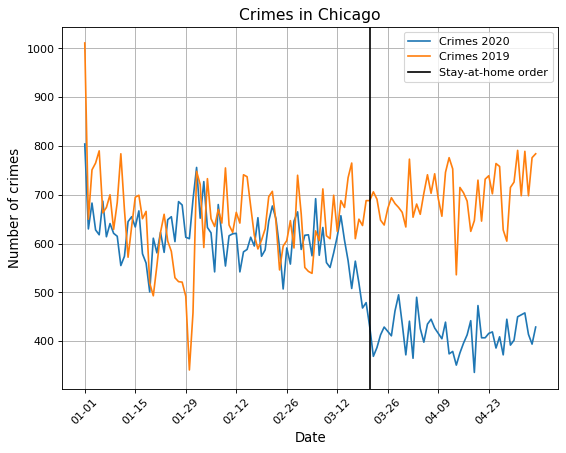

In [13]:
# dat2020["DateNew"] = dat2020["Date"].dt.date
# dat2019["DateNew"] = dat2019["Date"].dt.date
# dat2019 = dat2019[dat2019["DateNew"] <= dt.date(year=2019,month=4,day=18)]

# dat2020["DayMonth"] = dat2020.DateNew.map(lambda x: x.strftime('%m-%d'))
# plotdata2020 = dat2020.groupby("DayMonth").size()
# dates2020 = plotdata2020.index.to_numpy()
# plotdata2020 = plotdata2020.to_numpy()

# plotdata2019 = dat2019.groupby("DateNew").size()
# dates2019 = plotdata2019.index.to_numpy()
# plotdata2019 = plotdata2019.to_numpy()

plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(dates2020, plotdata2020, label = "Crimes 2020");
plt.plot(dates2020, plotdata2019, label = "Crimes 2019");
plt.axvline(x="03-21", color = "black", label="Stay-at-home order")
plt.legend();
plt.xticks(dates2020[::14], rotation = 45);
plt.xlabel("Date", size = 12);
plt.title("Crimes in Chicago", size = 14)
plt.grid()
plt.ylabel("Number of crimes", size = 12);

The black line shows when the stay-at-home orders were applied in the city of Chicago. We see there is a rapid difference between the crimes in 2020 and in 2019. However, the total number of crimes is not enough. It is also relevant to see which types of crimes have a difference. For this we will look at the period between 1st of March and 18th of April, which is the period where the corona-virus had a huge effect on the society. We will count up the total number of crimes for each of the chosen focus crimes. This can be done the following way:

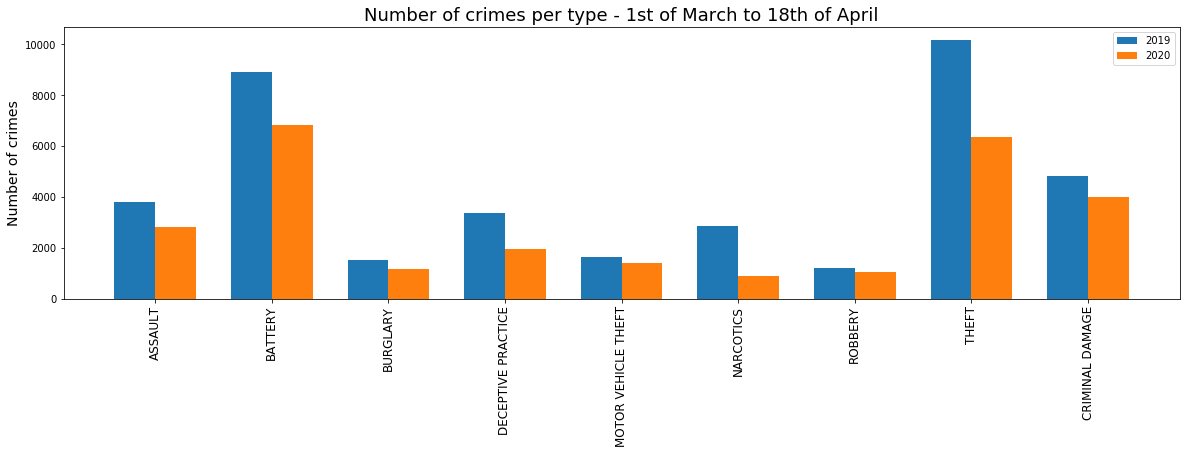

In [14]:
# Prepare data
tmp2019 = dat2019[dat2019["DateNew"] >= dt.date(year=2019,month=3,day=1)]
tmp2020 = dat2020[dat2020["DateNew"] >= dt.date(year=2020,month=3,day=1)]

# Focus crimes
focuscrimes = ['ASSAULT','BATTERY','BURGLARY','DECEPTIVE PRACTICE','MOTOR VEHICLE THEFT','NARCOTICS','ROBBERY','THEFT', 'CRIMINAL DAMAGE']

n_series = 2
n_obs = len(focuscrimes)
x = np.arange(n_obs)

# Plotting:
fig, ax = plt.subplots(figsize=(20,5))

# Determine bar widths
width_cluster = 0.7
width_bar = width_cluster/n_series

years = ["2019", "2020"]

for n in range(n_series):
    x_positions = x+(width_bar*n)-width_cluster/2
    a = np.zeros(n_obs)
    if n == 1:  
        for i in range(n_obs):
            a[i] = tmp2020[tmp2020["Primary Type"] == focuscrimes[i]]["Primary Type"].size
    else:
        for i in range(n_obs):
            a[i] = tmp2019[tmp2019["Primary Type"] == focuscrimes[i]]["Primary Type"].size
    
    ax.bar(x_positions, a, width_bar, align='edge', label = years[n])

x = np.arange(0,9,1)
ax.set_xticks(x)
# Set ticks labels for x-axis
ax.set_xticklabels(focuscrimes, rotation='vertical', fontsize=12);
plt.title("Number of crimes per type - 1st of March to 18th of April", size = 18)
plt.ylabel("Number of crimes",size=14);
plt.legend();
        


As we see, the biggest difference in number of crimes between 2019 and 2020 is definitely the THEFT category. The main reason for this is probably, that people are staying at home and thereby thefts are not very common in people's home. Further, a lot of shops are closed, so shoplifting is also another thing that will not happen. If we look relatively to each other, it is also quite clear that narcotics has seen a huge drop along with deceptive practice. 

So it is quite interesting to see how the data has seen significantly drops in some of the crimes, while crimes like robbery, criminal damage and burglary has not seen that big of an effect.


#### Location of data

Another interesting thing to look at is the location of the crimes. To get an overview, we can try to plot histograms over the location of the data. Here we can just choose a focus crime to look at. Narcotics might be the most interesting to see if there is a difference.



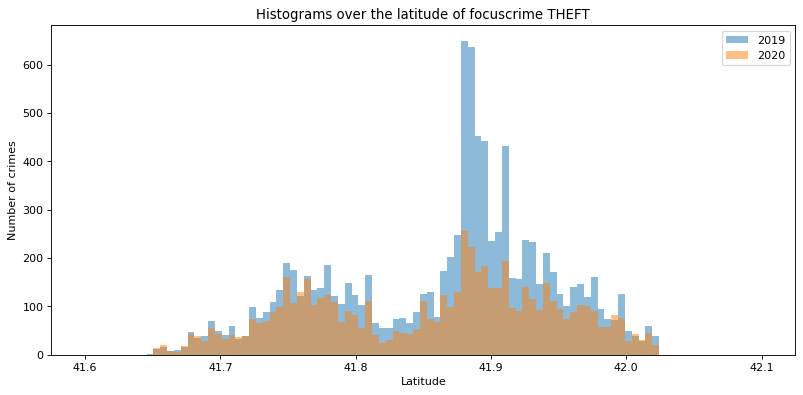

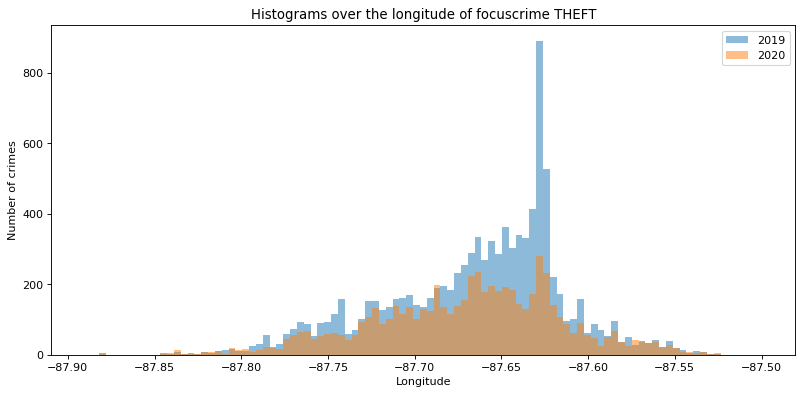

In [15]:
from matplotlib import pyplot

crime = "THEFT"

# Fix data by removing NANs and filter by crime chosen
tmp2019 = tmp2019.fillna(0)
tmp2020 = tmp2020.fillna(0)

locdat2019 = tmp2019[tmp2019["Primary Type"] == crime]
locdat2020 = tmp2020[tmp2020["Primary Type"] == crime]

locdat2019 = locdat2019[locdat2019["Latitude"] > 0]
locdat2020 = locdat2020[locdat2020["Latitude"] > 0]


# Create the bins:
bins = np.linspace(41.6, 42.1, 100)
bins2 = np.linspace(-87.89, -87.5, 100)

# Plot the histograms:
plt.figure(figsize=(12, 12), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)

pyplot.hist(locdat2019["Latitude"], bins, alpha=0.5, label='2019')
pyplot.hist(locdat2020["Latitude"], bins, alpha=0.5, label='2020')
pyplot.legend(loc='upper right')
plt.title("Histograms over the latitude of focuscrime " + crime)
plt.ylabel("Number of crimes")
plt.xlabel("Latitude")
pyplot.show()
plt.figure(figsize=(12, 12), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(2,1,2)
pyplot.hist(locdat2019["Longitude"],bins2, alpha=0.5, label='2019')
pyplot.hist(locdat2020["Longitude"],bins2, alpha=0.5, label='2020')
pyplot.legend(loc='upper right')
plt.title("Histograms over the longitude of focuscrime " + crime)
plt.ylabel("Number of crimes")
plt.xlabel("Longitude")
pyplot.show()

Interestingly, it can be seen that for most of the latitude and longitudes, almost the same amount of crimes has happened. However, in the middle of the city there is a major difference in the number of crimes, i.e. by coordinates around (41.9, -87.62). This is quite interesting, as it is there the major differences can be seen. 

By changing the 'crime' variable to some of the other focus crimes the distribution of other crimes can be seen. However, a similar pattern can be seen, and they are left out for readability of the notebook. 

We have thereby located the main focus of where the difference can be seen. This can be useful when creating visualizations showing the main difference.

Another thing to look at is the difference through all the years of the same time period. This will show whether or not the crimes in general has fallen through the years. Besided being bonus information and maybe quite interesting, it also provides information of whether or not a general decrease in crime has been seen. We will still be looking at one specific focus crime. However, one can quickly change the crime in order to see how it looks for others. This is kept out for simplicity, however under the visualizations section a visualization over this can be seen. It however might take quite a bit to run, given that the crime data is a large data file.

Also, we will look at just the years from 2010 and to present, for the days between 1st of March and 18th of April once again for a nice point of comparisson. 

In [16]:
# Filter the crime out
crime = "THEFT"
tmpdat = crimeDat[crimeDat["Primary Type"] == crime]
tmpdat.head(2)

ID Case Number                    Date                 Block  IUCR  \
3  11227293    JB147230  09/09/2017 08:17:00 PM  060XX S EBERHART AVE  0810   
8  11022695    JA353568  07/17/2017 10:10:00 AM   021XX W MC LEAN AVE  0810   

  Primary Type Description Location Description  Arrest  Domestic  ...  Ward  \
3        THEFT   OVER $500            RESIDENCE   False     False  ...  20.0   
8        THEFT   OVER $500            RESIDENCE   False     False  ...  32.0   

   Community Area  FBI Code  X Coordinate Y Coordinate  Year  \
3            42.0        06           NaN          NaN  2017   
8            22.0        06           NaN          NaN  2017   

               Updated On  Latitude Longitude  Location  
3  02/11/2018 03:57:41 PM       NaN       NaN       NaN  
8  07/24/2017 03:54:23 PM       NaN       NaN       NaN  

[2 rows x 22 columns]

In [17]:
# Make the data datetime values
tmpdat = tmpdat.reset_index()
tmpdat["DateNew"] = pd.to_datetime(tmpdat["Date"]).dt.date

In [18]:
# Filter the data to only contain the wished time period
tmpdat["DayMonth"] = tmpdat.DateNew.map(lambda x: x.strftime('%m-%d'))
tmpdat = tmpdat[tmpdat["DayMonth"] >= "03-01"]
tmpdat = tmpdat.reset_index()
tmpdat = tmpdat[tmpdat["DayMonth"] <= "04-18"]

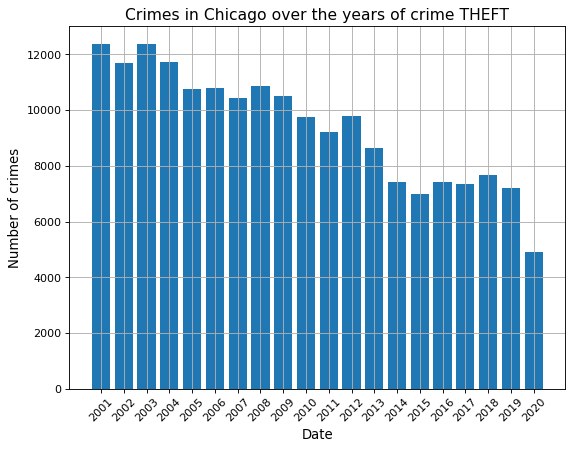

In [19]:
test = tmpdat.groupby("Year").size()
plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(test.index, test, label = "Crimes vver the years");
plt.xticks(test.index, rotation = 45);
plt.xlabel("Date", size = 12);
plt.title("Crimes in Chicago over the years of crime "+crime , size = 14)
plt.grid()
plt.ylabel("Number of crimes", size = 12);

As we see, the number of crimes has decreased through the years in that period. However, the crimes for the period in 2020 seems much less than the others and does not look like a natural development in the number of crimes. This supports the message this visualization wants to convey about the number of crimes being lower in 2020 due to the corona virus. As mentioned, this only shows the result for the focus crime THEFT. However, similar patterns can be seen for other crimes, which will be shown later in the visualization section.

Now it is time to look at the machine learning performed in this study.

### Machine Learning

For the machine learning part we will use convolutional neural networks.
First, we need to prepare the data. This has been done before, but since the training of the networks takes a long time, it is convenient to make the convolutional neural network(CNN) section "selfsufficient".

In [20]:
import pandas as pd
import numpy as np # For data handling
import matplotlib.pyplot as plt # For plotting
import datetime as dt
import urllib

from numpy import array
from numpy import hstack
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers.convolutional import Conv1D
from tensorflow.python.keras.layers.convolutional import MaxPooling1D
import matplotlib.dates as mdates
#!pip freeze

C:\Users\neelj\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\neelj\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\neelj\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\neelj\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

Preparation of corona data.

In [21]:
# # Data preparation:
# # Load the data:
# url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
# confirmedUS = pd.read_csv(url)

# url2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
# deathsUS = pd.read_csv(url2)

# # Rename the column Admin2 to County, since it is the name of the counties:
# confirmedUS = confirmedUS.rename(columns={"Admin2": "County"})
# deathsUS = deathsUS.rename(columns = {"Admin2": "County"})

# illiData = confirmedUS[confirmedUS["Province_State"] == "Illinois"]
# illiData = illiData.reset_index()
# illiData.at[illiData[illiData["County"] == "McHenry"].index, 'County'] = 'Mchenry'
# illiData.at[illiData[illiData["County"] == "McLean"].index, 'County'] = 'Mclean'
# illiData.at[illiData[illiData["County"] == "De Witt"].index, 'County'] = 'Dewitt'
# illiData.at[illiData[illiData["County"] == "McDonough"].index, 'County'] = 'Mcdonough'
# illiData.at[illiData[illiData["County"] == "LaSalle"].index, 'County'] = 'Lasalle'
# illiData.at[illiData[illiData["County"] == "DuPage"].index, 'County'] = 'Dupage'
# illiData.at[illiData[illiData["County"] == "DeKalb"].index, 'County'] = 'Dekalb'

# illiDataDeaths = deathsUS[deathsUS["Province_State"] == "Illinois"]
# illiDataDeaths = illiDataDeaths.reset_index()
# illiDataDeaths.at[illiDataDeaths[illiDataDeaths["County"] == "McHenry"].index, 'County'] = 'Mchenry'
# illiDataDeaths.at[illiDataDeaths[illiDataDeaths["County"] == "McLean"].index, 'County'] = 'Mclean'
# illiDataDeaths.at[illiDataDeaths[illiDataDeaths["County"] == "De Witt"].index, 'County'] = 'Dewitt'
# illiDataDeaths.at[illiDataDeaths[illiDataDeaths["County"] == "McDonough"].index, 'County'] = 'Mcdonough'
# illiDataDeaths.at[illiDataDeaths[illiDataDeaths["County"] == "LaSalle"].index, 'County'] = 'Lasalle'
# illiDataDeaths.at[illiDataDeaths[illiDataDeaths["County"] == "DuPage"].index, 'County'] = 'Dupage'
# illiDataDeaths.at[illiDataDeaths[illiDataDeaths["County"] == "DeKalb"].index, 'County'] = 'Dekalb'

In [22]:
## Get data for the states (meaning total number of cases for each state, disregarding counties)
tmp = illiData.groupby("Province_State").sum()
StateData = tmp.T
StateData = StateData.drop(StateData.index[0:6])
StateData = StateData.reset_index()
StateData = StateData.rename(columns={"index": "Date"})

# corona cases
state = "Illinois"
cordat = StateData[["Date",state]]
cordat["Date"] = pd.to_datetime(cordat["Date"])

Preparation of crime data for multivariate case.

In [23]:
# ## Load the data
# crimeDat = pd.read_csv("CrimesChicago.csv")
# # Data 2020
# dat2020 = crimeDat[crimeDat["Year"] >= 2020]
# dat2020 = dat2020.reset_index()
# dat2020["Date"] = pd.to_datetime(dat2020["Date"])

# dat2020["DateNew"] = dat2020["Date"].dt.date

# dat2020["DayMonth"] = dat2020.DateNew.map(lambda x: x.strftime('%m-%d'))
# plotdata2020 = dat2020.groupby("DayMonth").size()
# dates2020 = plotdata2020.index.to_numpy()
# plotdata2020 = plotdata2020.to_numpy()

In order to prepare the data for the nerwork, we want one observation for each of the four focuscrimes for every COVID-19 observation. The choosen focuscrimes are 'THEFT','NARCOTICS','BATTERY','DECEPTIVE PRACTICE'. We are only looking at crime data for 2020, since COVID-19 was not a problem in USA in 2019.

In [24]:
# Select focus crimes and merge data with the corona data set
# crimes data
#selecting focus crimes
crimegroups2020 = dat2020
crimegroups2020 = crimegroups2020.rename(columns = {"Primary Type": "Category"})
focuscrimes = ['THEFT','NARCOTICS','BATTERY','DECEPTIVE PRACTICE']
crimedat = crimegroups2020[crimegroups2020.Category.isin(focuscrimes)]

# counting icidents in each focuscrime
crimedat = crimedat.rename(columns = {"Primary Type": "Category"})
crimedat["dates"] = crimedat['Date'].dt.date
crimedat = crimedat.groupby(["dates","Category"]).count().reset_index()[["dates","Category","Description"]]
crimedat["dates"] = pd.to_datetime(crimedat["dates"])

# merging corona and crime data
table = pd.pivot_table(crimedat, values='Description', index=['dates'],
                    columns=['Category'], aggfunc=np.sum).reset_index()
mergedat =pd.merge(cordat,table, how='inner', left_on="Date", right_on="dates")
mergedat = mergedat.drop(columns=['dates'])

We have trained the models in advance and saved the predictions. The training takes a long time for the predictions to be accurate.
In the code, we first have a function for splitting the training data into samples. When having a timeseries as the COVID-19 data, we will have to specify which values to use for input and output. We have chosen to use 5 time steps for predicting the 6th time step. We can then split the timeseries into small samples by using the x=(i,i+1,i+2,i+3,i+4,i+5) and y=(i+6).

In [25]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

We will train the model on all the data avaiable until the the day the models are trained minus the 20 last days. We will use the last 20 days to see how well the model is performing.

In [26]:
# define input sequence
n_data = np.shape(cordat)[0]
start1 = n_data-20
raw_seq = cordat["Illinois"].to_numpy()[0:start1]
# choose a number of time steps
n_steps1 = 5
# split into samples
X, y = split_sequence(raw_seq, n_steps1)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features1 = 1
X = X.reshape((X.shape[0], X.shape[1], n_features1))

We have chosen to use 1D convolutional neural networks as they work well for temperal dependent data. Just like it would be natural to use a 2D convolutional neural network for images as images have a spatial dependency.
For the netvork we have chosen 3 convolutional layers with 32,64, and 128 filters respectively. Afterward, we use maxpooling and a dense layers. We have chosen to use ReLu as our activation function for all layers.

In [27]:
# define model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(n_steps1, n_features1)))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

Now it is time for training and testing the model. We fit 100 models, where each model is trained for 5000 epochs. This is high and we could be in danger of overfitting. However, this gave us the best one step predictions.

In [28]:
# # test model
n_fits1 = 100                                                    #change n_fits 100
ys = cordat["Illinois"].to_numpy()
yhat = np.zeros([n_data,n_fits1])
for j in range(n_fits1):
    # fit model
    model.fit(X, y, epochs=5000, verbose=0)                   #change epochs 5000
    for i in range(n_data-n_steps1):
        # demonstrate prediction
        x_input = cordat["Illinois"].to_numpy()[(i):(n_steps1+i)]
        x_input = x_input.reshape((1, n_steps1, n_features1))
        yhat[n_steps1+i,j] = model.predict(x_input, verbose=0)
        
np.save('yhat_uni_one_step.npy', yhat) # save

The code below follows the same template as introduced before. The difference is how we are splitting the data. As we now want to predict four time steps into the future, we will need to train the network on training data with four outcome values y. We choose to use 6 time steps as our input. Therefore, a sequnce of 10 values will be split so the first 6 values becomes our input x, and the last 4 values becomes our outcome y.

In [29]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# # define input sequence
# # choose a number of time steps
n_data = np.shape(cordat)[0]
n_steps_in2 = 6
n_steps_out2 = 4
start2 = np.shape(cordat)[0]
raw_seq = cordat["Illinois"].to_numpy()[0:start2]
# split into samples
X, y = split_sequence(raw_seq, n_steps_in2, n_steps_out2)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features2 = 1
X = X.reshape((X.shape[0], X.shape[1], n_features2))
# define model
model = Sequential()
model.add(Conv1D(filters=34, kernel_size=2, activation='relu', input_shape=(n_steps_in2, n_features2)))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_steps_out2))
model.compile(optimizer='adam', loss='mse')

# # test model
n_fits2 = 100                                                      #change fits 100
ys = cordat["Illinois"].to_numpy()
yhat = np.empty(n_steps_out2)
for j in range(n_fits2):
    # fit model
    model.fit(X, y, epochs=5000, verbose=0)                      #change epochs 5000
    x_input = cordat["Illinois"].to_numpy()[(n_data-n_steps_in2):(n_data)]
    x_input = x_input.reshape((1, n_steps_in2, n_features2))
    y_out = model.predict(x_input, verbose=0)
    yhat += y_out[0]
yhat /= n_fits2

np.save('yhat_multiple_step.npy', yhat) # save

Now we will use the crime date for one step predictions. The amount COVID-19 cases is increasing the amount of crime is decreasing. It can be argumented that the relationship is not multivariate, but the decreasing crime rate is merely a consequence. However, we will model the network as it was a multivariate relationship between variables.

In [30]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# # define input sequence
n_data = np.shape(mergedat)[0]
n_features3 = np.shape(mergedat)[1]-1
# choose a number of time steps
n_steps_in3 = 5
n_steps_out3 = 1
# choose training data
start3 = np.shape(cordat)[0]-20
in_seq13 = mergedat["BATTERY"].to_numpy()[0:start3]
in_seq23 = mergedat["DECEPTIVE PRACTICE"].to_numpy()[0:start3]
in_seq33 = mergedat["NARCOTICS"].to_numpy()[0:start3]
in_seq43 = mergedat["THEFT"].to_numpy()[0:start3]
out_seq3 = mergedat["Illinois"].to_numpy()[0:start3]
# convert to [rows, columns] structure
in_seq13 = in_seq13.reshape((len(in_seq13), 1))
in_seq23 = in_seq23.reshape((len(in_seq23), 1))
in_seq33 = in_seq33.reshape((len(in_seq33), 1))
in_seq43 = in_seq43.reshape((len(in_seq43), 1))
out_seq3 = out_seq3.reshape((len(out_seq3), 1))
# horizontally stack columns
dataset = hstack((in_seq13, in_seq23, in_seq33, in_seq43, out_seq3))
# convert into input/output
X, y = split_sequences(dataset, n_steps_in3, n_steps_out3)
# flatten output
n_output3 = y.shape[1] * y.shape[2]
y = y.reshape((y.shape[0], n_output3))
# the dataset knows the number of features
n_features3 = X.shape[2]

# define model
model = Sequential()
model.add(Conv1D(filters=34, kernel_size=2, activation='relu', input_shape=(n_steps_in3, n_features3)))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_output3))
model.compile(optimizer='adam', loss='mse')

# # test model
n_fits3 = 100                                                       # change fits 100
ys = mergedat[["BATTERY","DECEPTIVE PRACTICE","NARCOTICS","THEFT","Illinois"]].to_numpy()
xx,yy = np.shape(mergedat[["BATTERY","DECEPTIVE PRACTICE","NARCOTICS","THEFT","Illinois"]])
yhat = np.zeros([xx,yy,n_fits3])
for j in range(n_fits3):
    # fit model
    model.fit(X, y, epochs=10000, verbose=0)                      #change epoch 10000
    for i in range(n_steps_in3):
        yhat[i,:,j] = np.mean(mergedat[["BATTERY","DECEPTIVE PRACTICE","NARCOTICS","THEFT","Illinois"]].to_numpy()[0:n_steps_in3],axis=0)
    for i in range(n_data-n_steps_in3):
        # demonstrate prediction
        x_input = mergedat.loc[(i):(n_steps_in3+i-1), ["BATTERY","DECEPTIVE PRACTICE","NARCOTICS","THEFT","Illinois"]].to_numpy()
        x_input = x_input.reshape((1, n_steps_in3, n_features3))
        yhat[n_steps_in3+i,:,j] = model.predict(x_input, verbose=0)
        
yhat = np.mean(yhat,axis=2)
np.save('yhat_multivariate.npy', yhat) # save

## Genre

The general genre of the project based on [this text](http://vis.stanford.edu/files/2010-Narrative-InfoVis.pdf) is a mix of annotated charts and partitioned poster. This is due to the different charts shown throughout the project with explanatory text and the different maps shown. The combination fits well together, given that it creates a deep understanding from the graphs supported by the maps. 

The following is an overview of the different tools used for the overall narrative of the story.

### Visual Narrative

* Visual Structuring

The visual platform of the web page is consistent, given that it uses maps and graphs thoughout to tell the narrative. It tells the story by showing the user data in a consistent manner.

* Highlighting

A big part of the highlighting in the web page is zooming and interaction/feature distinction to get the message conveyed. It also helps the user to interact. 

* Transition Guidance

The is an object continuity throughout the page and it has familiar objects to most users. These are the two main tools in transition. However, most transitions are carried by explanatory text, which is more of a narrative structure than a visual one. 

### Narrative Structure


* Ordering

The web page has linear ordering, as it tells a story from the start to the end. At each point of the story, it is supported by visualizations and references to articles around the internet.

* Interactivity

Hover highlighting can be seen in the map over the coronavirus. There is a filtering/selection part of the plots of the crimes where one can choose the specific crime one wants to look at. There is, however, also a quite extensive explicit instruction and introduction to each part of the web page. This is to more fluently tell the story.

* Messaging

There is a lot of captions and headlines throughout the web page to explain to the user what the story is that is wanted to be conveyed. Further, there are some annotations and introductory text. There is quite a lot of text and references throughout to help the user understand. Most of the tools within messaging is actually used. 

## Visualizations

The goal of the visualizations in this study is to show the message of corona virus' impact on the crimes in Chicago. For this, an introduction of how Corona has evolved and impacted the state of Illinois and Chicago will be performed, mentioning different articles about this topic and using a folium map. Thereafter a bit of the impact in regards to movement data in the Chicago area and then finally into the important stuff about the crimes. 

The goal is to use what we have learned throughout the social data analysis course. Of most importance for this, is the use of folium maps and bokeh plots to create interactivity. The interactivity helps the user to dive into the important stuff and to encourage curiousness within the data.

In the end, a bit of machine learning will be shown in order to convey the message that it can be used to forecast data as used in this study.

These types of visualizations are great for the story we want to convey, given that it shows the narrative in a simple way. This is so everyone can get the story, no matter what the background of the user is. The simple graphs and maps encourages the user to investigate the current situation.

### Corona data

As explained, as an introduction the Corona virus data will be presented in the state of Illinois. To do so, a plot showing how it evolved over time as well as a map with hover features will be created. For the hover feature, a geojson file will be used to make a choropleth over the state. This can be done in the following steps:

First by preparing the data:

In [31]:
# Packages
import pandas as pd
import numpy as np # For data handling
import matplotlib.pyplot as plt # For plotting
import datetime as dt
import urllib
import geojson
import folium

# Load the data:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
confirmedUS = pd.read_csv(url)

url2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
deathsUS = pd.read_csv(url2)

# Rename the column Admin2 to County, since it is the name of the counties:
confirmedUS = confirmedUS.rename(columns={"Admin2": "County"})
deathsUS = deathsUS.rename(columns = {"Admin2": "County"})

# Rename counties to be the same as in the geojson file we will be using for both data sets:
illiData = confirmedUS[confirmedUS["Province_State"] == "Illinois"]
illiData = illiData.reset_index()
illiData.at[illiData[illiData["County"] == "McHenry"].index, 'County'] = 'Mchenry'
illiData.at[illiData[illiData["County"] == "McLean"].index, 'County'] = 'Mclean'
illiData.at[illiData[illiData["County"] == "De Witt"].index, 'County'] = 'Dewitt'
illiData.at[illiData[illiData["County"] == "McDonough"].index, 'County'] = 'Mcdonough'
illiData.at[illiData[illiData["County"] == "LaSalle"].index, 'County'] = 'Lasalle'
illiData.at[illiData[illiData["County"] == "DuPage"].index, 'County'] = 'Dupage'
illiData.at[illiData[illiData["County"] == "DeKalb"].index, 'County'] = 'Dekalb'


illiDataDeaths = deathsUS[deathsUS["Province_State"] == "Illinois"]
illiDataDeaths = illiDataDeaths.reset_index()
illiDataDeaths.at[illiDataDeaths[illiDataDeaths["County"] == "McHenry"].index, 'County'] = 'Mchenry'
illiDataDeaths.at[illiDataDeaths[illiDataDeaths["County"] == "McLean"].index, 'County'] = 'Mclean'
illiDataDeaths.at[illiDataDeaths[illiDataDeaths["County"] == "De Witt"].index, 'County'] = 'Dewitt'
illiDataDeaths.at[illiDataDeaths[illiDataDeaths["County"] == "McDonough"].index, 'County'] = 'Mcdonough'
illiDataDeaths.at[illiDataDeaths[illiDataDeaths["County"] == "LaSalle"].index, 'County'] = 'Lasalle'
illiDataDeaths.at[illiDataDeaths[illiDataDeaths["County"] == "DuPage"].index, 'County'] = 'Dupage'
illiDataDeaths.at[illiDataDeaths[illiDataDeaths["County"] == "DeKalb"].index, 'County'] = 'Dekalb'

The data is loaded from github under the URLs that can be seen. Some of the names need to be renamed in order to fit the geojson file for making the choropleth. This is because the data will be matched to keys in the geojson data, and the keys has to fit the names. Now that is done, a folium map will be created. It will use logaritmic numbers for scaling the choropleth, and on hover it will show the amount of confirmed cases and the amount of deaths in each county for the newest date.

In [32]:
# Load geojson data:
url= 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/illinois-counties.geojson'
response = urllib.request.urlopen(url)
county_geo = geojson.loads(response.read())
date = "5/10/20"

# Get the data of the states:
state_data = illiData[["County",date, "Lat", "Long_"]]
state_data = state_data.reset_index()
# Make it logarithmic for the choropleth scales:
state_data[date] = np.log(state_data[date]+1)
 
# Initialize the map:
m = folium.Map(location=[40.000000, -89], zoom_start=7)

# Insert the hover values into the geojson file:
for i in county_geo.features:
    i.properties["Cases"] = round(np.exp(state_data[state_data["County"] == i.properties['name']][date].to_numpy()[0]))
    i.properties["Deaths"] = int(illiDataDeaths[illiDataDeaths["County"] == i.properties['name']][date].to_numpy()[0])

# Create the choropleth and add it to the map:
choro = folium.Choropleth(
 geo_data=county_geo,
 name='COVID-19',
 data=state_data,
 columns=['County', date],
 key_on='feature.properties.name',
# threshold_scale=[0, 100, 500, 1000, 20000],
 fill_color='YlGn',
 fill_opacity=0.6,
 line_opacity=0.2,
 highlight=True,
 legend_name='Amount of confirmed cases (logarithmic)'
).add_to(m)
folium.LayerControl().add_to(m)

# Add the geojson features we added earlier to the labels:
style_function = "font-size: 12px; font-weight: bold"
choro.geojson.add_child(
    folium.features.GeoJsonTooltip(['name', 'Cases', 'Deaths'], style=style_function, labels=True))

m

Now one can hover over each of the counties and see the name, number of confirmed cases and number of confirmed deaths. What we want to convey is that the situation is very bad around larger cities, especially in Cook county around Chicago. This is to support that the Corona situation in Chicago is rather bad. Further, we want to show how it evolved over time in the entire state compared to Cook county to also show how bad the situation is there compared to a lot of other places. This can be done by a simple plot. First by preparing the data:

In [33]:
## Get data for the states (meaning total number of cases for each state, disregarding counties)
# First, sum the different states, if more entries of one state
tmp = illiData.groupby("Province_State").sum()

# Transpose the data frame:
StateData = tmp.T

# Remove unwanted rows:
StateData = StateData.drop(StateData.index[0:6])

# Rename the first column:
StateData = StateData.reset_index()
StateData = StateData.rename(columns={"index": "Date"})
StateData
# Now every column is a state (except for date), and every row corresponds to a date

Province_State     Date  Illinois
0               1/22/20       0.0
1               1/23/20       0.0
2               1/24/20       1.0
3               1/25/20       1.0
4               1/26/20       1.0
..                  ...       ...
109             5/10/20   77741.0
110             5/11/20   79007.0
111             5/12/20   83021.0
112             5/13/20   84694.0
113             5/14/20   87937.0

[114 rows x 2 columns]

Now we can make the plot. It should be noted, that the stay-at-home order in Chicago was applied the 21st of March, 2020. Thereby it would make sense to also show that in the plot. It will look like the following:

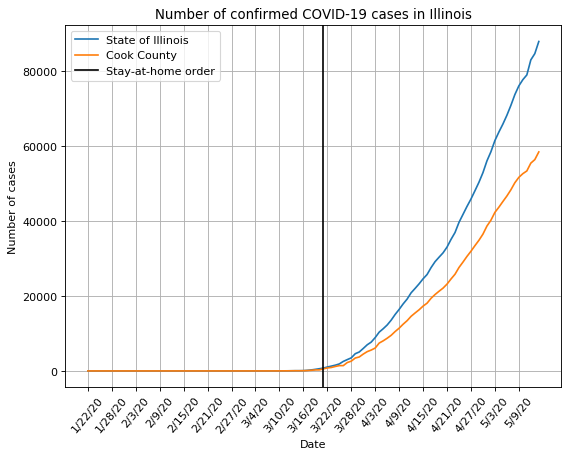

In [34]:
# Write the state:
state = "Illinois"
# Get the state data
dat = StateData[state]
tmp = StateData["Date"]
# Get the cook county data
dat2 = illiData[illiData["County"] == "Cook"]
dat2 = dat2.T
dat2 = dat2.drop(dat2.index[0:12])
#plt.plot(dat2.to_numpy())


# Make the plot for Illinois and Cook county:
fig=plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(tmp, dat, label = "State of Illinois")
plt.plot(tmp, dat2, label = "Cook County")
plt.axvline(x="3/21/20", color = "black", label="Stay-at-home order")
plt.xticks(np.arange(0, len(dat), step=6), tmp[np.arange(0, len(dat), step=6)], rotation=50);
plt.xlabel("Date");
plt.ylabel("Number of cases");
plt.title("Number of confirmed COVID-19 cases in "+ state);
plt.legend()
plt.grid();

As we see, Cook County take up a huge majority of the total number of cases in Illinois. It is thereby very relevant to look at Chicago, since it is in Cook County and it ensures that the corona virus had an impact on Chicago. 

Another thing to look at is the stay at home order.

### Stay-at-home orders

We want to use the movement data to ensure that people are staying at home in this period. It is important, since it also supports the message about the crimes. When people are home, it should be expected that the crimes would decrease. It also shows that people are actually following the stay at home orders. We already showed the plot, but we will show it again as it is how the narrative should evolve naturally.

The plot is rather simple and can be done the following way:

In [35]:
## Load the mobility data
url3 = 'https://raw.githubusercontent.com/descarteslabs/DL-COVID-19/master/DL-us-mobility-daterow.csv'
mobility = pd.read_csv(url3)
mobility = mobility.rename(columns = {"admin1": "State", "admin2": "County"})

# Get the Illinois data:
illiMob = mobility[mobility["State"] == "Illinois"]
illiMob = illiMob.reset_index()

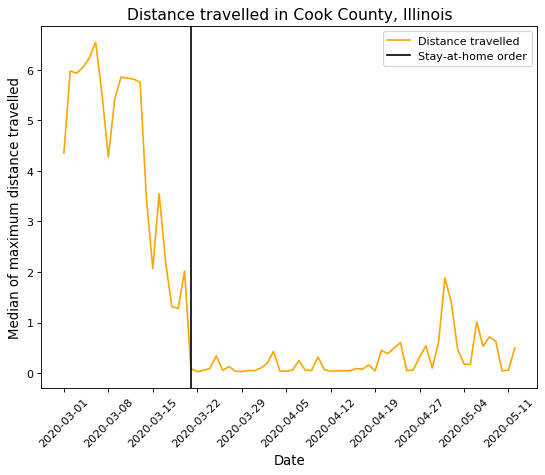

In [36]:
# Plot at test. Let us focus on Cook County, which is where Chicago is.
test = illiMob[illiMob["County"] == "Cook County"]
dates = test["date"]
fig=plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(dates, test["m50"], color = "orange", label = "Distance travelled")
plt.axvline(x="2020-03-21", color = "black", label="Stay-at-home order")
plt.title("Distance travelled in Cook County, Illinois", size = 14)
plt.ylabel("Median of maximum distance travelled", size = 12)
plt.xlabel("Date", size = 12)
#plt.grid()
plt.legend()
plt.xticks(dates[::7], rotation = 45);

Again we are showing when the stay-at-home orders where introduced. We see for the data, that after the stay-at-home orders were applied, people are moving much less. This shows that people are following the stay-at-home orders. So people are staying at home due to the corona-virus. This is interesting, we can thereby look at the crimes in the area.

## Crimes in Chicago

The crimes in Chicago is the essence of the study - but the narrative is that the corona-virus has impacted the crimes. First off, we want to show the total number of crimes to get an introduction as we did earlier in the data-analysis. The plot looks the following:


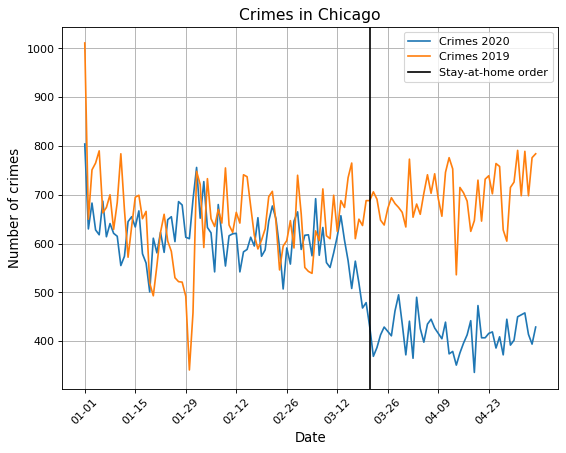

In [37]:
# import datetime as dt
# dat2020["DateNew"] = dat2020["Date"].dt.date
# dat2019["DateNew"] = dat2019["Date"].dt.date
# dat2019 = dat2019[dat2019["DateNew"] <= dt.date(year=2019,month=4,day=18)]


# dat2020["DayMonth"] = dat2020.DateNew.map(lambda x: x.strftime('%m-%d'))
# plotdata2020 = dat2020.groupby("DayMonth").size()
# dates2020 = plotdata2020.index.to_numpy()
# plotdata2020 = plotdata2020.to_numpy()

# plotdata2019 = dat2019.groupby("DateNew").size()
# dates2019 = plotdata2019.index.to_numpy()
# plotdata2019 = plotdata2019.to_numpy()



plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(dates2020, plotdata2020, label = "Crimes 2020");
plt.plot(dates2020, plotdata2019, label = "Crimes 2019");
plt.axvline(x="03-21", color = "black", label="Stay-at-home order")
plt.legend();
plt.xticks(dates2020[::14], rotation = 45);
plt.xlabel("Date", size = 12);
plt.title("Crimes in Chicago", size = 14)
plt.grid()
plt.ylabel("Number of crimes", size = 12);

We have already seen this plot, but it conveys the message that the number of crimes has decreased rapidly compared to 2019. Also as an introduction, we want to show why we chose to focus on the crimes we did. Which can be supported by the following plot:

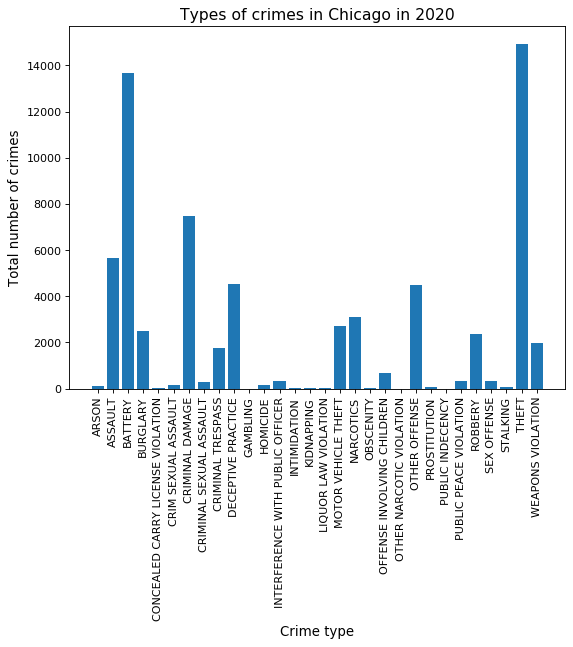

In [38]:
tmp = dat2020.groupby("Primary Type").size()
plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(tmp.index, tmp)
plt.xticks(rotation = 90);
plt.title("Types of crimes in Chicago in 2020", size = 14);
plt.xlabel("Crime type", size = 12);
plt.ylabel("Total number of crimes", size = 12);

The reason why we show this plot is to make the user understand why we choose the crimes we do and to eliminate wondering.

### Bokeh plots

Now it is time to show the real interactive plots. We will use bokeh to create a plot where it is possible to click the legend on the type of crime one wants to investigate. When the crime has been chosen, a plot over how it evolved in 2020 and in 2019 will be shown. This is so one can easily see the difference and how some crimes have a greater difference than others. It encourages wondering why that is so. The bokeh plot will be made the following way:


First we will load some packages and create the figure we want to add the data to:

In [39]:
# Importing some packages for plotting:
from bokeh.palettes import Spectral8
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import Legend, Span
output_notebook()

# Focus crimes:
focuscrimes = ['ASSAULT','BATTERY','BURGLARY','DECEPTIVE PRACTICE','MOTOR VEHICLE THEFT','NARCOTICS','ROBBERY','THEFT', 'CRIMINAL DAMAGE']

# Create the figure:
p = figure(plot_height=500,plot_width = 1100, x_axis_type = "datetime")
p.title.text = 'Focus Crimes in Chicago. Year 2019 and 2020. Black line shows stay-at-home order.'


Loading BokehJS ...

Now we want to prepare the data for adding to the plot. This can be done the following way:

In [40]:
# Get the data and the dates:
tmp = dat2020.groupby("DateNew").size()
tmp2 = dat2020.groupby("DayMonth").size()
dates = tmp.index.to_numpy()
dates2 = tmp2.index.to_numpy()

# The date when stay-at-home orders were applied:
stayathomedate = dates[dates == dt.date(year=2020,month=3,day=21)]

# Empty array for the legend items
legend_ = []


Not it is time for the main loop, adding the lines to the legend entries and adding colors. It can be done the following way. The test1 and test2 lines are only for another legend showing which color corresponds to the years and will have no clicking.

We also add a line showing the stay-at-home order by using Span. It will all be added to the figure.

In [41]:
i = 0
for name in focuscrimes:
    data = dat2020[dat2020["Primary Type"] == name] # Get the crime
    data = data.groupby("DateNew").size().to_numpy() # Number of crimes grouped by dates.
    data2 = dat2019[dat2019["Primary Type"] == name]# Get the crime
    data2 = data2.groupby("DateNew").size().to_numpy() # Number of crimes grouped by dates
    # Add to figure:
    c = p.line(dates, data, line_width = 2, color = 'blue', alpha = 0.8, visible = False)
    c2 = p.line(dates, data2, line_width = 2, color = 'orange', alpha = 0.8, visible = False)
    test = p.line(dates[0], data[0], line_width = 2, color = 'blue', alpha = 0.8, visible = True)
    test2 = p.line(dates[0], data[0], line_width = 2, color = 'orange', alpha = 0.8, visible = True)
    i += 1
    # Add to legend:
    legend_.append((name, [c, c2]))

# Stay at home line:
stayathome = Span(location=stayathomedate[0],
                            dimension='height', line_color='black',
                            line_dash='dashed', line_width=1)
p.add_layout(stayathome) # Add to figure.

Now it is time to create the legend with the interactivity. This can be done the following way:

In [42]:
# To empty arrays for 2020 and 2019
legend_it = []
legend_it2 = []

# Add the legends to the figure for the two years:
legend_it.append(("2020", [test]))
legend_it2.append(("2019", [test2]))
legend2 = Legend(items = legend_it, location = (0, 0))
legend3 = Legend(items = legend_it2, location = (0, 0))
p.add_layout(legend2, 'right')
p.add_layout(legend3, 'right')

# Add the main legend to the figure:
legend = Legend(items = legend_, location = (0,100))
p.add_layout(legend, 'left')
p.yaxis.axis_label = 'Number of crimes'
p.xaxis.axis_label = 'Date'
p.legend.click_policy = "hide"

Finally we can show the plot:

In [43]:
show(p)

As it can be seen, the figure has been created and it is possible to click on the crime one wants to look at and get the graph. This makes it easy to choose the crime and see the main difference between 2019 and 2020.

Another plot we want to make is the difference between the previous 10 years in the same time period, much as we did previously for THEFT. We also want this to be a bokeh plot, where one can select the crime and see the development. This is much as we did in the lecture, where we create a bar chart using different crimes showing different years. To do so, we first have to prepare the data however. This can be done the following way:

First we just get the data we need (all data after 2010):

In [44]:
bardat = crimeDat[crimeDat.Year >= 2010]

Next we make a numpy array, where each column corresponds to a focus crime and each row corresponds to a year. This is quite time-consuming, but can be done the following way, where each entry correspond to number of crimes between 1st of March and 18th of April for the crime and year.

In [45]:
years = [i for i in range(2010,2021)]
A = np.zeros((len(years), len(focuscrimes)))
c1 = 0
for i in years:
    tmp1 = bardat[bardat["Year"] == i]
    tmp1 = tmp1.reset_index()
    c2 = 0
    for j in focuscrimes:
        tmp2 = tmp1[tmp1["Primary Type"] == j]
        tmp2 = tmp2.reset_index()
        tmp2["Date"] = pd.to_datetime(tmp2["Date"]).dt.date
        tmp2 = tmp2[tmp2["Date"] <= dt.date(year=i,month=4,day=18)]
        tmp2 = tmp2[tmp2["Date"] >= dt.date(year=i,month=3,day=1)]
        A[c1,c2] = len(tmp2.Date)
        c2 += 1
    c1 += 1

print(A)

[[3117. 9695. 3147. 1803. 2190. 6623. 1645. 9754. 6080.]
 [2807. 8354. 3022. 1622. 2663. 5740. 1584. 9203. 5104.]
 [2804. 8027. 2582. 1801. 2173. 5387. 1390. 9781. 4969.]
 [2337. 7134. 2058. 1948. 1662. 5118. 1291. 8630. 4083.]
 [2193. 6454. 1729. 2493. 1344. 4313. 1059. 7409. 3663.]
 [2242. 6601. 1385. 2375. 1184. 3788. 1008. 6982. 3788.]
 [2519. 6637. 1583. 2585. 1252. 2360. 1237. 7435. 3964.]
 [2439. 6312. 1460. 2614. 1300. 1719. 1287. 7334. 3760.]
 [2558. 6195. 1376. 2655. 1187. 1917. 1144. 7662. 3653.]
 [2698. 6392. 1069. 2515. 1204. 2156.  869. 7221. 3378.]
 [2151. 5189.  854. 1460.  982.  758.  782. 4898. 2965.]]


As we see, we now have the array we want with the total number of crimes.

When this is done, we convert it back to a dataframe and create the right names for the columns. Further, we also create a column corresponding to the years. This can, quite simply, be done the following way:

In [46]:
c = 0
tmp = np.zeros(len(years), int)
for i in range(2010,2021):
    tmp[c] = str(i)
    c = c+1


A = np.c_[A, tmp]
bardataset = pd.DataFrame({focuscrimes[0]: A[:, 0], 
                           focuscrimes[1]: A[:, 1], 
                           focuscrimes[2]: A[:,2],
                           focuscrimes[3]: A[:,3],
                           focuscrimes[4]: A[:,4],
                           focuscrimes[5]: A[:,5],
                           focuscrimes[6]: A[:,6],
                           focuscrimes[7]: A[:,7], 
                           focuscrimes[8]: A[:,8], 
                           "years": A[:,9].astype(int)})
bardataset["years"] = bardataset["years"].astype(str)

In [47]:
focuscrimes

['ASSAULT',
 'BATTERY',
 'BURGLARY',
 'DECEPTIVE PRACTICE',
 'MOTOR VEHICLE THEFT',
 'NARCOTICS',
 'ROBBERY',
 'THEFT',
 'CRIMINAL DAMAGE']

Now we can create the bokeh plot. The first thing we do is load the packages and create the figure to add the data:

In [48]:
# Import packages:
from bokeh.io import output_file, show, output_notebook, curdoc
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, FactorRange,Grid, LinearAxis, Plot, VBar, LabelSet, Legend
output_notebook()
# Array for the years:
years = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']

# Create the figure:
q = figure(title = "Number of crimes each year. Click legend to show plot.",x_range = FactorRange(factors=years),plot_height=500,plot_width = 1100,toolbar_location=None, tools="") #p is a standard way to call figures in Bokeh

Loading BokehJS ...

Now we add the different bar-plots to the figure created by a simple for loop using the dataframe we have just created:

In [49]:
# Create the source file
sourcetest = ColumnDataSource(bardataset)
bar ={} # to store vbars
### here we will do a for loop:
for indx,i in enumerate(focuscrimes):
     bar[i] = q.vbar(x='years', top=i, source=sourcetest,alpha = 0.9, width = 0.9,muted_alpha=0.1, visible = False) 
        # Muted alpha is how much the colors are muted (low makes it more muted, making it easier to distinguish.)
        # Muted true: Everything is muted, Muted False: Everything starts not muted. i stands for a column that we use, top=y; we are specifying that our numbers comes from column i

# Some x-axis stuff.
q.x_range.range_padding = 0.1
q.xgrid.grid_line_color = None

Now we create the legend over the bars we created above. This can be done the following way:

In [50]:
items = []
for i in focuscrimes:
    items.append((i, [bar[i]]))
    
    
legend = Legend(items = items, location = (0, 100))
q.add_layout(legend, 'left')

Lastly we show the plot

In [51]:
q.yaxis.axis_label = 'Number of crimes'
q.xaxis.axis_label = 'Year'

q.legend.click_policy="hide" ### assigns the click policy
show(q) #displays the plot

Now we have a bokeh plot showing how the different types of crimes have developed over the years. This is another way of looking at the different crimes to see how it has developed.

### Heat maps:

As we saw earlier, the locations where the crimes have happened is also quite interesting. To show this, heat maps will be created over some of the crimes in both 2019 and 2020. The goal of the heat maps is to show where the biggest impact of the corona virus has been.

First we will look at the focus crime THEFT.

#### Theft

The first thing we do in order to make the heat map is to filter the data to get the data from 1st of March to 18th of April as in the other plots. This is done the following way:


In [52]:
heattheft1 = dat2020[dat2020["Primary Type"] == "THEFT"]
heattheft1 = heattheft1.fillna(0)
heattheft2 = dat2019[dat2019["Primary Type"] == "THEFT"]
heattheft2 = heattheft2.fillna(0)
heattheft1 = heattheft1[heattheft1["DateNew"] >= dt.date(year=2020,month=3,day=1)]
heattheft2 = heattheft2[heattheft2["DateNew"] >= dt.date(year=2019,month=3,day=1)]

Next we create two different maps. One for 2019 and one for 2020.

In [53]:
# Load packages
from folium import plugins
from folium.plugins import HeatMap

# First create the map
map_heat1 = folium.Map(location=[41.881832, -87.623177],
                    tiles = 'Stamen Toner', zoom_start = 12)


# Make the data:
heat_data = [[row['Latitude'],row['Longitude']] for index, row in heattheft1.iterrows()]
# Plot it on the map
HeatMap(heat_data, name=None, min_opacity=0.4, max_zoom=20, max_val=1.0, radius=15, blur=15, gradient=None, overlay=True, control=True, show=True).add_to(map_heat1)


# Do the same for the second map:
map_heat2 = folium.Map(location=[41.881832, -87.623177],
                    tiles = 'Stamen Toner', zoom_start = 12)


# Make the data:
heat_data2 = [[row['Latitude'],row['Longitude']] for index, row in heattheft2.iterrows()]
# Plot it on the map
HeatMap(heat_data2, name=None, min_opacity=0.4, max_zoom=20, max_val=1.0, radius=15, blur=15, gradient=None, overlay=True, control=True, show=True).add_to(map_heat2)

Last thing is to display the two maps side by side. This can be done by using some imports from IPython.core. We can display the maps side by side the following way:

In [54]:
from IPython.core.display import display, HTML

# Make the maps side by side
htmlmap = HTML('<iframe srcdoc="{}" style="float:left; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           '<iframe srcdoc="{}" style="float:right; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           .format(map_heat1.get_root().render().replace('"', '&quot;'),500,500,
                   map_heat2.get_root().render().replace('"', '&quot;'),500,500))
# Display the maps
display(htmlmap)

C:\Users\neelj\anaconda3\lib\site-packages\IPython\core\display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


As we see, it is now possible to zoom in and out on the maps independently and looking at the main differences. We see that there are quite some differences in the downtown area. However, it is possible to find other differences when delving into the maps.

The same thing can be done looking at the crime NARCOTICS which is also a very interesting crime to look at due to rapid decrease.

#### Narcotics

Similarly, we prepare the data and create the two maps as before:

In [55]:
# Prepare the data
heatnarc1 = dat2020[dat2020["Primary Type"] == "NARCOTICS"]
heatnarc1 = heatnarc1.fillna(0)
heatnarc2 = dat2019[dat2019["Primary Type"] == "NARCOTICS"]
heatnarc2 = heatnarc2.fillna(0)
heatnarc1 = heatnarc1[heatnarc1["DateNew"] >= dt.date(year=2020,month=3,day=1)]
heatnarc2 = heatnarc2[heatnarc2["DateNew"] >= dt.date(year=2019,month=3,day=1)]

# Create the first map:
map_heat1 = folium.Map(location=[41.881832, -87.623177],
                    tiles = 'Stamen Toner', zoom_start = 12)


# Make the data:
heat_data = [[row['Latitude'],row['Longitude']] for index, row in heatnarc1.iterrows()]
# Plot it on the map
HeatMap(heat_data, name=None, min_opacity=0.5, max_zoom=20, max_val=1.0, radius=15, blur=15, gradient=None, overlay=True, control=True, show=True).add_to(map_heat1)


# Create the second map:
map_heat2 = folium.Map(location=[41.881832, -87.623177],
                    tiles = 'Stamen Toner', zoom_start = 12)


# Make the data:
heat_data2 = [[row['Latitude'],row['Longitude']] for index, row in heatnarc2.iterrows()]
# Plot it on the map
HeatMap(heat_data2, name=None, min_opacity=0.5, max_zoom=20, max_val=1.0, radius=15, blur=15, gradient=None, overlay=True, control=True, show=True).add_to(map_heat2)

Then we display the maps using the same method as before:

In [56]:
htmlmap = HTML('<iframe srcdoc="{}" style="float:left; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           '<iframe srcdoc="{}" style="float:right; width: {}px; height: {}px; display:inline-block; width: 50%; margin: 0 auto; border: 2px solid black"></iframe>'
           .format(map_heat1.get_root().render().replace('"', '&quot;'),500,500,
                   map_heat2.get_root().render().replace('"', '&quot;'),500,500))
display(htmlmap)

As we see again the downtown area has seen some differences, but also much the western part of Chicago and the airports. It is quite interesting to delve into these maps since one can zoom in and get the exact locations or one can zoom out and get a general overview.

The last thing to look at is the visualizations in regards to the machine learning.

## Prediction of the future

The focus until now has been to show the reader how the crimes in Chicago has developed as a result of the COVID-19 virus and the stay-at-home orders. We saw a rapid decrease. It was shown how specific types of crimes have developed and how they were different from previous years. Further, it was shown where the crimes have happened in both 2019 and 2020 to give the user an overview of the locations of the crimes.

Now we want to show how well one can predict crimes and corona data using machine learning. It should be noted, that machine learning only takes data into account. Therefore, these predictions might not be accurate due to outer forces working on the data. However, we will show in general that predictions can be used to somewhat accurately assess data.

The goal of this section is not to understand the underlying statistics, but rather getting the user to see how statistics can perform on data like the what is presented on this webpage.

### Corona Data

The first model we have developed is an univariate convolutional neural network. We are looking at the the confirmed COVID-19 cases, and the goal of the model is to make accurate one-step predictions. We are training the model on all data available except for the last 20 days.

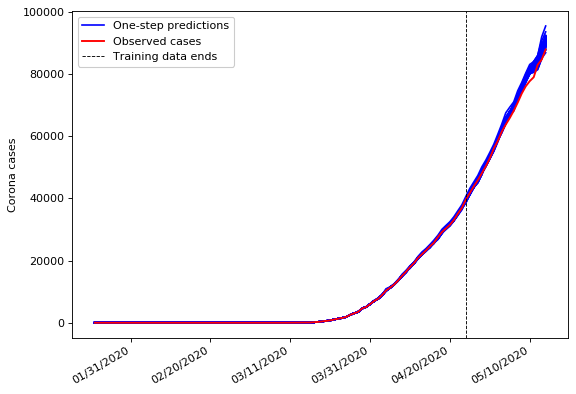

In [57]:
# # define input sequence
# n_data = np.shape(cordat)[0]
# start = n_data-20
# raw_seq = cordat["Illinois"].to_numpy()[0:start]
# # choose a number of time steps
# n_steps = 5

# n_fits1 = 100                                                    #change n_fits
ys = cordat["Illinois"].to_numpy()

yhat = np.load('yhat_uni_one_step.npy') # load

plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=20))
for j in range(n_fits1):
    if (j==0):
        plt.plot(cordat.Date,yhat[:,j],linewidth=1.5, color='blue',label="One-step predictions")
    else:
        plt.plot(cordat.Date,yhat[:,j],linewidth=1.5, color='blue')
#plt.plot(cordat.Date,np.mean(yhat,axis=1),linewidth=1.7, color='blue',label="One-step predictions")
plt.plot(cordat.Date,ys,linewidth=1.7, color='red',label="Observed cases")
plt.axvline(x=cordat.Date[start1-1],color="black",linewidth=0.8,label="Training data ends", linestyle='dashed')
plt.gcf().autofmt_xdate()
plt.legend(framealpha=1, frameon=True)
plt.ylabel('Corona cases')
plt.show()

In the plot the blue lines are representing the one step predictions for 100 models. Convolutional neural networks have a stochastic behaviour. However, we see in the plot that the prediction is pretty accurate for predicting tomorrow. If we make our prediction for tomorrow the mean of 100 models, we would expect a good result. However, for these models there is a huge exception. The model are learning the development of the COVID-19 cases, the model can only predict a development it has seen before. That is if a government initiative is introduced, the model will not be able to predict the outcome.

The example above is introduced as a proof of concept to see if convolutional neural networks can be used at all for prediction the COVID-19 cases. Now we will predict four time steps into the future. 

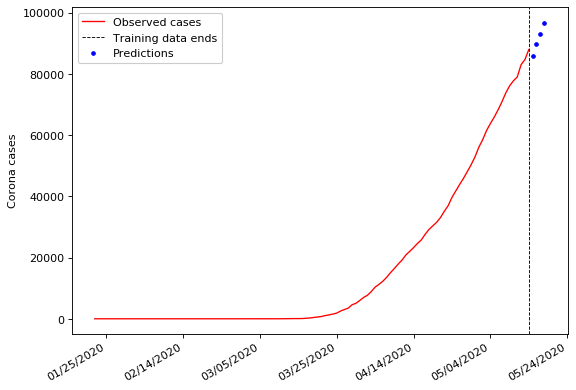

In [58]:
n_data = np.shape(cordat)[0]
# n_steps_in = 6
# n_steps_out = 4
# start = np.shape(cordat)[0]

# n_fits2 = 100                                                      #change fits
ys = cordat["Illinois"].to_numpy()
yhat = np.load('yhat_multiple_step.npy') # load

base = pd.to_datetime(cordat["Date"].to_numpy()[n_data-1])
date_list = [base + dt.timedelta(days=x) for x in range(1,n_steps_out2+1,1)]
date_list = pd.to_datetime(date_list)

plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=20))
plt.plot(cordat.Date,ys,linewidth=1.2, color='red', label='Observed cases')
plt.scatter(date_list,yhat,s=10, color='blue', label='Predictions') 
plt.gcf().autofmt_xdate()
plt.axvline(x=pd.to_datetime(cordat.Date[start2-1]),color="black",linewidth=0.8,label="Training data ends", linestyle='dashed')
plt.legend(framealpha=1, frameon=True)
plt.ylabel('Corona cases')
plt.show()

The mean of the predictions for 100 models for the next four days can be seen. However, please take it with a grain of salt. 

Now we will use the crime date for one step predictions. The amount COVID-19 cases is increasing the amount of crime is decreasing. It can be argumented that the relationship is not multivariate, but the decreasing crime rate is merely a consequence. However, we will model the network as it was a multivariate relationship between variables.

First, we will show theone step predictions for the focuscrimes "BATTERY","DECEPTIVE PRACTICE","NARCOTICS", and "THEFT". The predictions are plotted as a mean for 100 models with the convolutional neural network for the multivariate data set. 

In [59]:
# n_data = np.shape(mergedat)[0]
# n_features = np.shape(mergedat)[1]-1
# # choose a number of time steps
# n_steps_in = 5
# n_steps_out = 1
# # choose training data
# start = np.shape(cordat)[0]-20

# n_fits3 = 100                                                       # change fits
# ys = mergedat[["BATTERY","DECEPTIVE PRACTICE","NARCOTICS","THEFT","Illinois"]].to_numpy()

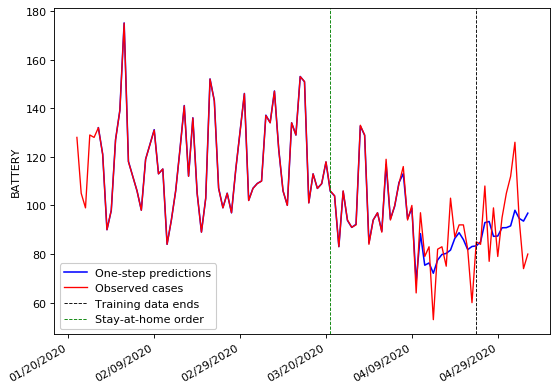

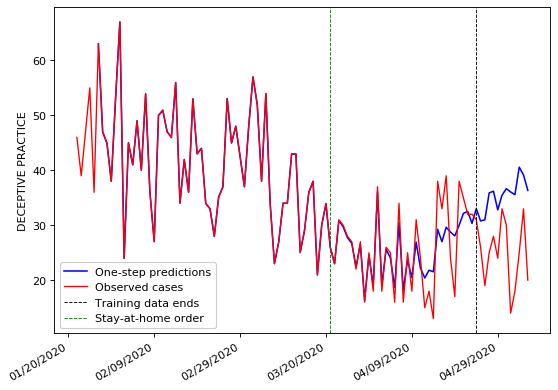

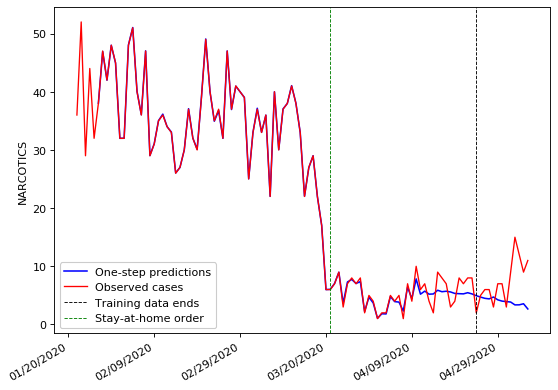

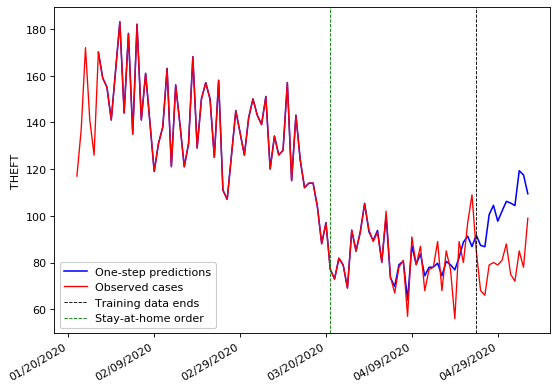

In [60]:
ys = mergedat[["BATTERY","DECEPTIVE PRACTICE","NARCOTICS","THEFT","Illinois"]].to_numpy()
plotdata_yhat = np.load('yhat_multivariate.npy') # load

cases = list(["BATTERY","DECEPTIVE PRACTICE","NARCOTICS","THEFT","Corona cases"])
for i in range(n_features3-1):
    plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=20))
    plt.plot(mergedat.Date[5:np.shape(plotdata_yhat)[0]],plotdata_yhat[5:np.shape(plotdata_yhat)[0],i],linewidth=1.4, color='blue',label="One-step predictions") 
    plt.plot(mergedat.Date,ys[:,i],linewidth=1.2, color='red',label="Observed cases")
    plt.axvline(x=pd.to_datetime(cordat.Date[start3-1]),color="black",linewidth=0.8,label="Training data ends", linestyle='dashed')
    plt.axvline(x=cordat.Date[59],color="green",linewidth=0.8, linestyle='dashed', label="Stay-at-home order")
    plt.gcf().autofmt_xdate()
    plt.legend(framealpha=1, frameon=True)
    plt.ylabel(cases[i])
    plt.show()

It is seen that the one step prediction become inaccurate after the stay at home order is introduced. However, the inaccuracy is larger after the training data set is ending and the models are treading unkown ground. Furthermore, it is seen that the amount of crime before the stay at home order follow stationary processess, this stops just days before the stay at home order.

Disregards the missing predictions at the begining, this is just a design choice as we are not using padding. We need 5 observation before we can start predicting.

Overall, it is seen that the predictions for the different types of crimes are not good. However, it is interesting to see if the COVID-19 one step predictions are improved by using the information from the crime data set.

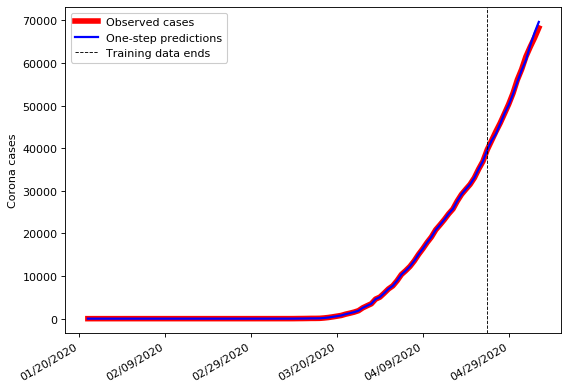

In [61]:
i=4
plt.figure(figsize=(8, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=20))
plt.plot(mergedat.Date,ys[:,i],linewidth=5, color='red',label="Observed cases")
plt.plot(mergedat.Date,plotdata_yhat[:,i],linewidth=2, color='blue',label="One-step predictions") 
plt.axvline(x=pd.to_datetime(cordat.Date[start3-1]),color="black",linewidth=0.8,label="Training data ends", linestyle='dashed')
plt.gcf().autofmt_xdate()
plt.legend(framealpha=1, frameon=True)
plt.ylabel(cases[i])
plt.show()

In the plot, it is hard to distinguish the predicted and observed values. Actually, the lines a plotted almost perfectly on top of eachother. This means that even though the predictions of the different types of crimes was mediocre the predictions for COVID-19 are good. However, before we get to excited, we should again note that the model has a big limitation. The model can only predict developments it has seen before. 

Further work could be to develop a model that predicts several time steps into the future using the crime data.

## Discussion

We are generally happy with how the web page is formed. However, there are some things that could have been added to provide a better insight.

We think that the general message have been nicely conveyed, however it could maybe have been done in a more elegant manner. There are a lot of general simple graphs, which are nice to show data, but not very exciting to look at. Another think that is nice about this is, that it seems original. A lot of articles throughout the internet are talking about crime and corona, however not a lot of nice visualizations have been created showing it. Therefore it seems very relevant and original to delve deeper into the data and use the data to show users how exactly the crimes are affected in a city like Chicago, which is known as a quite criminal city. The tools used in this course like bokeh plots and folium maps also created a nice basis for the visualzations to be shown. 

...


## Contributions

The web page has been created by two people; s164184 and s164379. Given the current situation, we have not been able to meet up. Thereby, the work load has been split up. 

### s164184

s164184 has done the following on the project (also the text in association with the points):

* Corona virus data - handling and illustrations (maps and graphs)
* Movement data - handling and illustrations (graphs)
* Crime data - handling and illustrations (the heat maps, bokeh plots and graphs)
* Also the same for the explainer notebook. Corona virus data, movement data and crime data.

### s164379

s164379 has done the following on the project (also the text in association with the points):

* Machine learning and predictions. All graphs, data handling and explainer notebook in relation to the machine learning.
* Creating the webpage from the project jupyter notebook